# CNU annual report probability visualisation
This notebook loads the CNU annual report BERT outputs, combines them with a year column, and plots trends of how often each label is predicted strongly across multiple thresholds. Run it after placing the yearly CSVs in `CNUdata/`.


In [1]:
# One-time install of plotting libraries (uncomment if needed)
%pip install -q matplotlib seaborn



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 120)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)

CODE_PREFIX = "CNU"

data_dir = Path("CNUdata")
csv_paths = sorted(data_dir.glob(f"preds-CNU*.csv"))
page_counts_path = Path("outputs/page_counts.csv")

csv_paths


[PosixPath('CNUdata/preds-CNU2012.csv'),
 PosixPath('CNUdata/preds-CNU2013.csv'),
 PosixPath('CNUdata/preds-CNU2014.csv'),
 PosixPath('CNUdata/preds-CNU2015.csv'),
 PosixPath('CNUdata/preds-CNU2016.csv'),
 PosixPath('CNUdata/preds-CNU2017.csv'),
 PosixPath('CNUdata/preds-CNU2018.csv'),
 PosixPath('CNUdata/preds-CNU2019.csv'),
 PosixPath('CNUdata/preds-CNU2020.csv'),
 PosixPath('CNUdata/preds-CNU2021.csv'),
 PosixPath('CNUdata/preds-CNU2022.csv'),
 PosixPath('CNUdata/preds-CNU2023.csv'),
 PosixPath('CNUdata/preds-CNU2024.csv')]

In [3]:
# Load all yearly CSVs and attach a year column from the filename
def load_yearly(paths):
    if not paths:
        raise FileNotFoundError(f"No CSVs found for pattern preds-{CODE_PREFIX}*.csv in {data_dir}")
    frames = []
    for path in paths:
        year = int(path.stem.replace(f"preds-{CODE_PREFIX}", ""))
        df = pd.read_csv(path)
        df["year"] = year
        df["word_count"] = df["sentence"].fillna("").str.split().str.len()
        frames.append(df)
    return pd.concat(frames, ignore_index=True)


def load_page_counts(path):
    if not path.exists():
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts = pd.read_csv(path)
    required_cols = {"code_year", "pages"}
    missing_cols = required_cols - set(page_counts.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in page counts file: {missing_cols}")
    page_counts = page_counts[page_counts["code_year"].astype(str).str.startswith(CODE_PREFIX)]
    if page_counts.empty:
        return pd.DataFrame(columns=["year", "page_count"])
    page_counts["year"] = page_counts["code_year"].str.extract(r"(\d{4})").astype(int)
    page_counts = page_counts[["year", "pages"]].rename(columns={"pages": "page_count"})
    return page_counts

# Run scripts/page_counts.py to generate outputs/page_counts.csv from PDFs in reports/
page_counts = load_page_counts(page_counts_path)

df = load_yearly(csv_paths)
df.head()


sentence  \
0  EBITDA $399m Earnings before interest, income tax, depreciation and amortisation Dividend 14.6 Cents per share (see ...   
1                          The new Chorus is up and running, working from the outset to get people and processes in place.   
2                   Chorus awarded Aon Hewitt Best Employers Accreditation following 85% engagement in first staff survey.   
3  P.2 P.2 P.4-5 P.6 F.1 P.7 Management Commentary & Financial Statements (follows P.6) Governance & Disclosures (follo...   
4  P. 2 A pleasing start Report from chairman Sue Sheldon and CEO Mark Ratcliffe Chorus’ first ‘year’ as a standalone c...   

   source_page source_pdf  prob_fin_label  prob_soc_label  prob_env_label  \
0            1    CNU2012        0.998360        0.001509        0.016370   
1            1    CNU2012        0.003536        0.998689        0.001136   
2            1    CNU2012        0.329688        0.981046        0.000436   
3            1    CNU2012        0.003752        0.012478        0.976232   
4            2    CNU2012        0.999436        0.004585        0.001615   

   prob_maori_label  year  word_count  
0          0.001327  2012          50  
1          0.004495  2012          18  
2          0.000626  2012          14  
3          0.001003  2012          18  
4          0.007264  2012          26

In [4]:
# Quick data health check
prob_cols = ["prob_fin_label", "prob_soc_label", "prob_env_label", "prob_maori_label"]
display(df[["year"] + prob_cols].describe(include="all"))


year  prob_fin_label  prob_soc_label  prob_env_label  \
count  15466.000000    15466.000000    15466.000000    15466.000000   
mean    2018.169016        0.417157        0.273384        0.301138   
std        3.662342        0.451098        0.410979        0.417550   
min     2012.000000        0.000294        0.000113        0.000094   
25%     2015.000000        0.005985        0.001257        0.003024   
50%     2018.000000        0.094950        0.003966        0.015024   
75%     2021.000000        0.989091        0.677781        0.810904   
max     2024.000000        0.999648        0.999203        0.999328   

       prob_maori_label  
count      15466.000000  
mean           0.017298  
std            0.083773  
min            0.000061  
25%            0.000975  
50%            0.001807  
75%            0.003057  
max            0.999230

In [5]:
# Reshape to long format for easier analysis across labels
long_df = df.melt(
    id_vars=["year", "word_count"],
    value_vars=prob_cols,
    var_name="label",
    value_name="probability"
)
long_df["label"] = long_df["label"].str.replace("prob_", "").str.replace("_label", "").str.upper()
long_df.head()


year  word_count label  probability
0  2012          50   FIN     0.998360
1  2012          18   FIN     0.003536
2  2012          14   FIN     0.329688
3  2012          18   FIN     0.003752
4  2012          26   FIN     0.999436

In [6]:
# Helpers to summarize and plot strong predictions at arbitrary thresholds
BASE_YEAR = 2018

def summarize_over_threshold(df_long, threshold):
    over_mask = df_long["probability"] > threshold
    enriched = df_long.assign(
        over=over_mask,
        over_word_count=lambda d: d["word_count"].where(over_mask, 0)
    )

    agg = (
        enriched
        .groupby(["year", "label"])
        .agg(
            total_sentences=("probability", "size"),
            total_words=("word_count", "sum"),
            over_count=("over", "sum"),
            over_share=("over", "mean"),  # same as count/total sentences
            over_word_count=("over_word_count", "sum"),
            mean_prob_over=("probability", lambda s: s[s > threshold].mean() if (s > threshold).any() else 0.0),
            sum_prob_over=("probability", lambda s: s[s > threshold].sum()),
        )
        .reset_index()
    )
    agg = agg.merge(page_counts, on="year", how="left")
    agg["page_count"] = agg["page_count"].replace({0: pd.NA})
    agg["over_sentence_word_share"] = agg["over_count"] / agg["total_words"]
    agg["over_word_share"] = agg["over_word_count"] / agg["total_words"]
    agg["sentences_per_page"] = agg["total_sentences"] / agg["page_count"]
    agg["over_sentences_per_page"] = agg["over_count"] / agg["page_count"]
    agg["over_words_per_page"] = agg["over_word_count"] / agg["page_count"]
    agg["theme_rate_per_1000_words"] = np.where(
        agg["total_words"] > 0,
        (agg["over_count"] / agg["total_words"]) * 1000,
        0.0,
    )
    non_theme = agg["total_sentences"] - agg["over_count"]
    agg["theme_ratio_per_1000_sentences"] = np.where(
        non_theme > 0,
        (agg["over_count"] / non_theme) * 1000,
        0.0,
    )
    base_counts = agg["label"].map(
        agg.loc[agg["year"] == BASE_YEAR, ["label", "over_count"]]
        .drop_duplicates(subset=["label"])
        .set_index("label")["over_count"]
    )
    agg["theme_index_base"] = np.where(
        base_counts > 0,
        (agg["over_count"] / base_counts) * 100,
        0.0,
    )
    agg["avg_theme_score_relevant"] = agg["mean_prob_over"]
    agg["threshold"] = threshold
    return agg


thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
summaries = {thr: summarize_over_threshold(long_df, thr) for thr in thresholds}

# Quick peek at the first threshold summary
preview_threshold = thresholds[0]
summaries[preview_threshold].head()


year  label  total_sentences  total_words  over_count  over_share  \
0  2012    ENV             1067        27985         307    0.287723   
1  2012    FIN             1067        27985         370    0.346767   
2  2012  MAORI             1067        27985           8    0.007498   
3  2012    SOC             1067        27985         232    0.217432   
4  2013    ENV             1064        28130         314    0.295113   

   over_word_count  mean_prob_over  sum_prob_over  page_count  \
0             8563        0.963376     295.756440          44   
1            10113        0.958237     354.547567          44   
2              251        0.894465       7.155718          44   
3             5295        0.959355     222.570423          44   
4             8768        0.964217     302.764215          48   

   over_sentence_word_share  over_word_share  sentences_per_page  \
0                  0.010970         0.305985           24.250000   
1                  0.013221         0.361372           24.250000   
2                  0.000286         0.008969           24.250000   
3                  0.008290         0.189209           24.250000   
4                  0.011162         0.311696           22.166667   

   over_sentences_per_page  over_words_per_page  theme_rate_per_1000_words  \
0                 6.977273           194.613636                  10.970163   
1                 8.409091           229.840909                  13.221369   
2                 0.181818             5.704545                   0.285867   
3                 5.272727           120.340909                   8.290155   
4                 6.541667           182.666667                  11.162460   

   theme_ratio_per_1000_sentences  theme_index_base  avg_theme_score_relevant  \
0                      403.947368         95.046440                  0.963376   
1                      530.846485         78.059072                  0.958237   
2                        7.554297        200.000000                  0.894465   
3                      277.844311         65.536723                  0.959355   
4                      418.666667         97.213622                  0.964217   

   threshold  
0        0.7  
1        0.7  
2        0.7  
3        0.7  
4        0.7

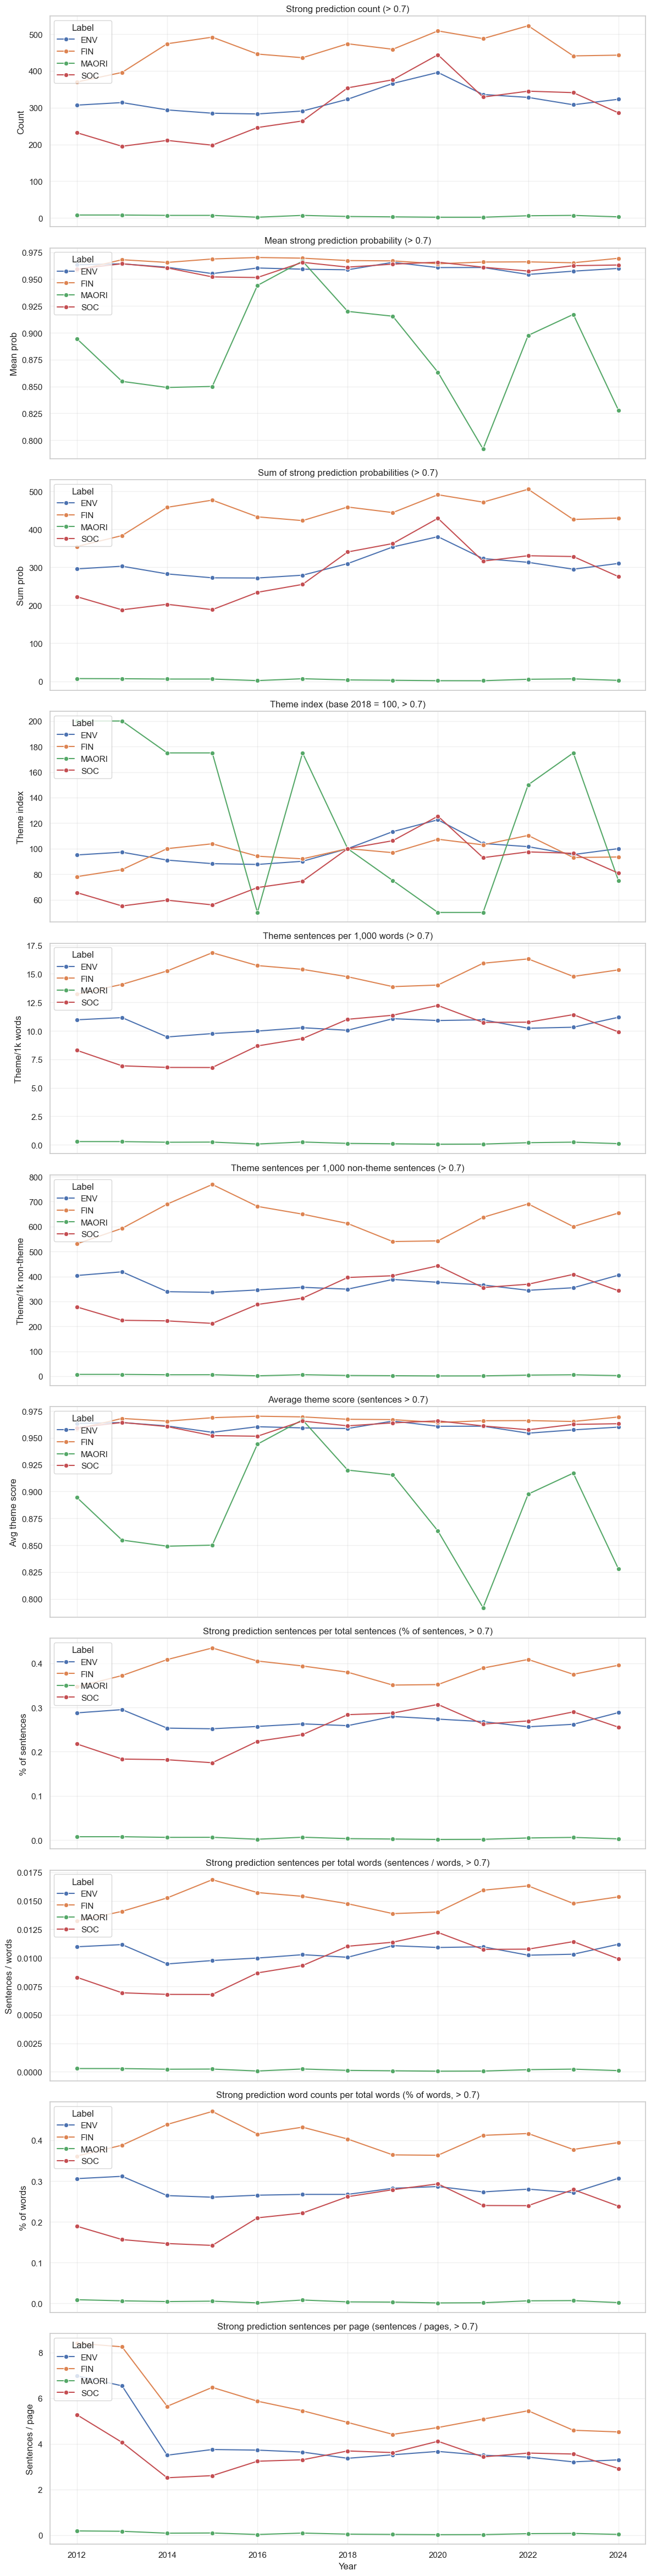

In [7]:
# Combined view for threshold > 0.7 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.7)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.7)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.7)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.7)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.7)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.7)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.7)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.7)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.7)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.7)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.7)"),
]
summary = summaries[0.7]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


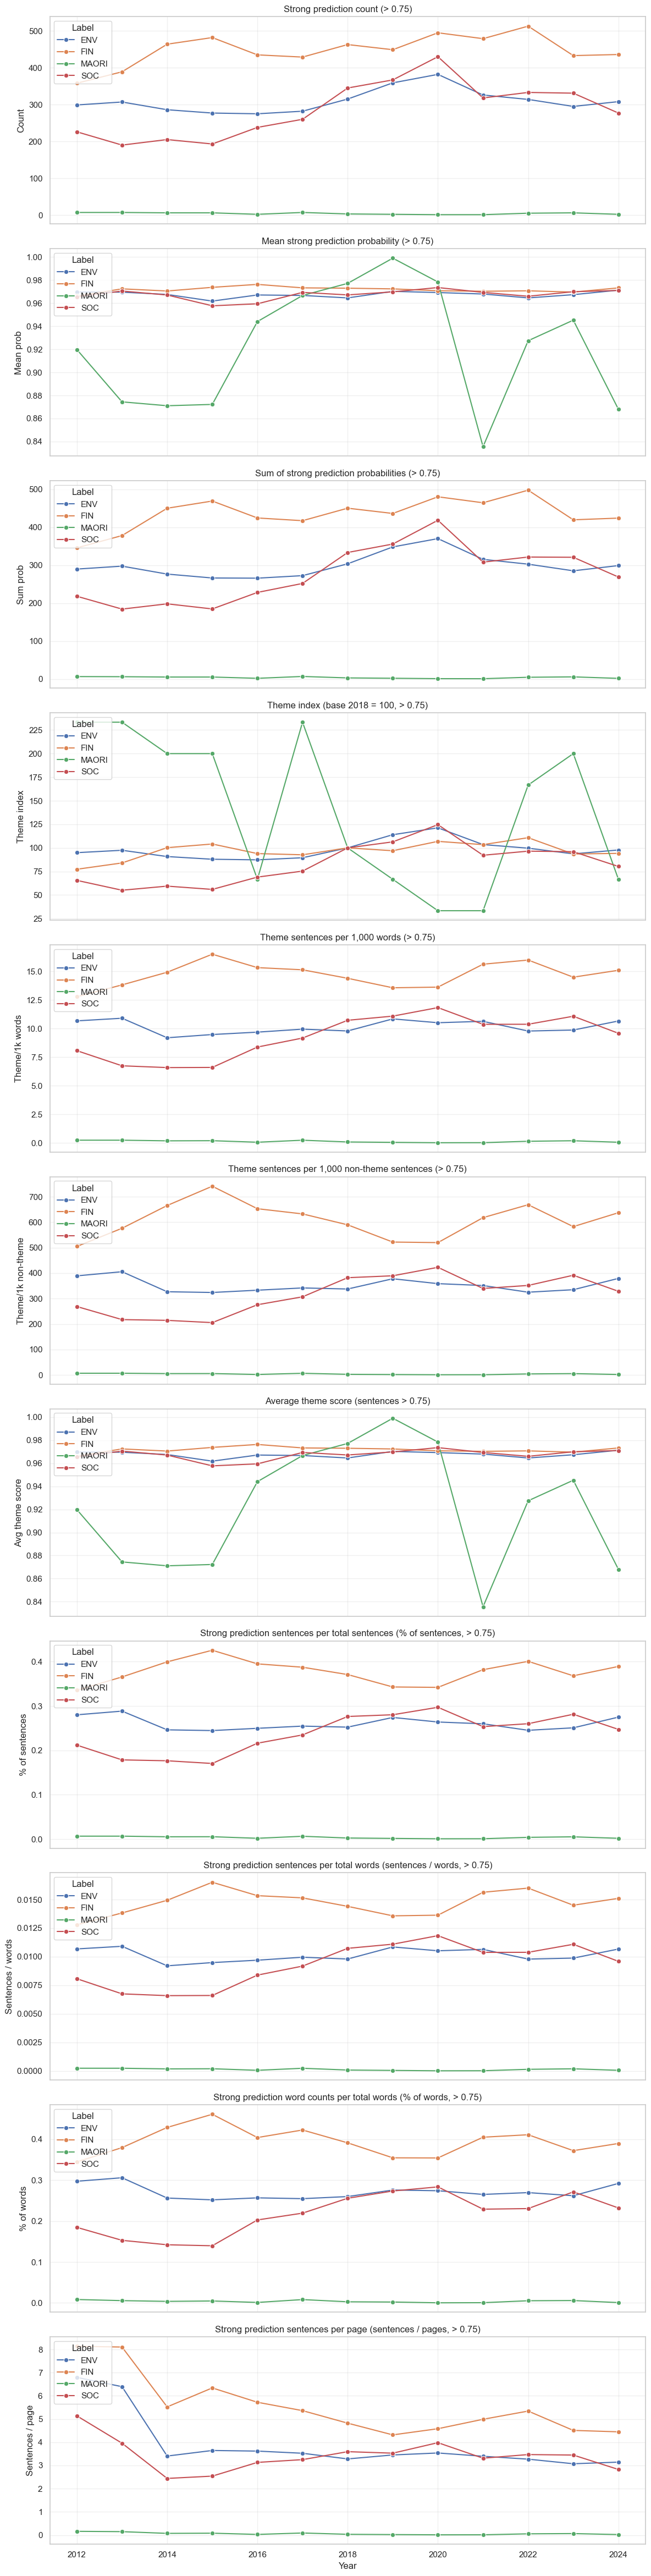

In [8]:
# Combined view for threshold > 0.75 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.75)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.75)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.75)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.75)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.75)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.75)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.75)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.75)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.75)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.75)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.75)"),
]
summary = summaries[0.75]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


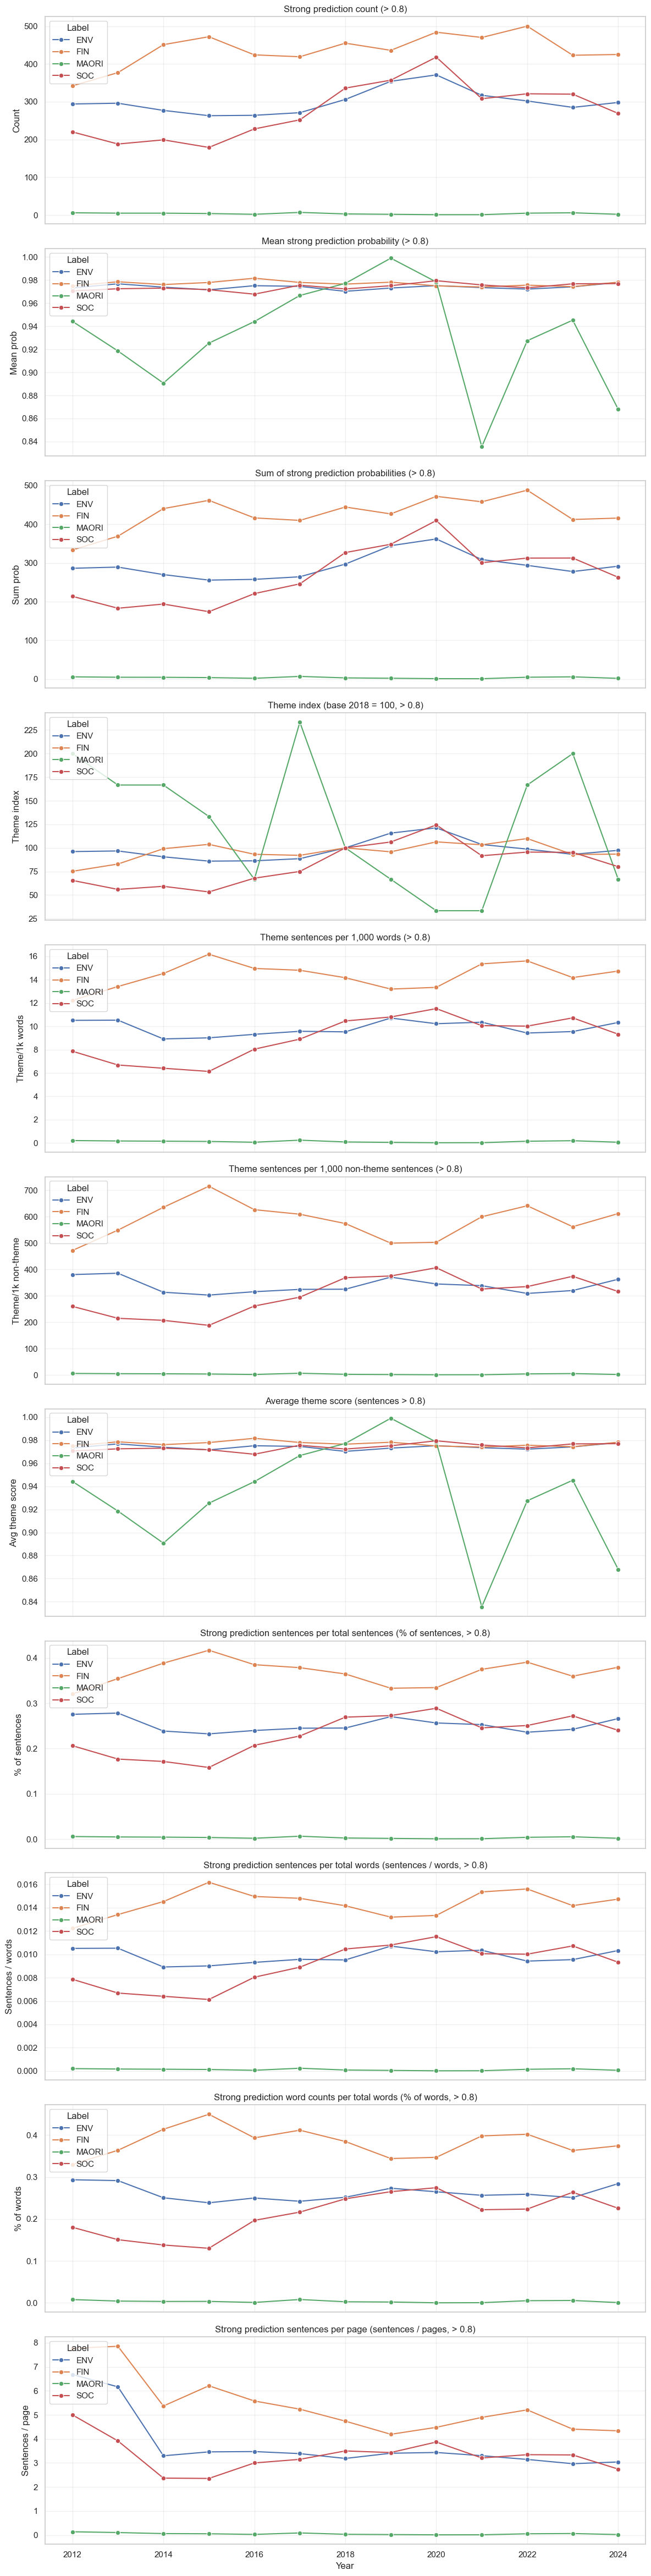

In [9]:
# Combined view for threshold > 0.8 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.8)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.8)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.8)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.8)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.8)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.8)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.8)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.8)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.8)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.8)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.8)"),
]
summary = summaries[0.8]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


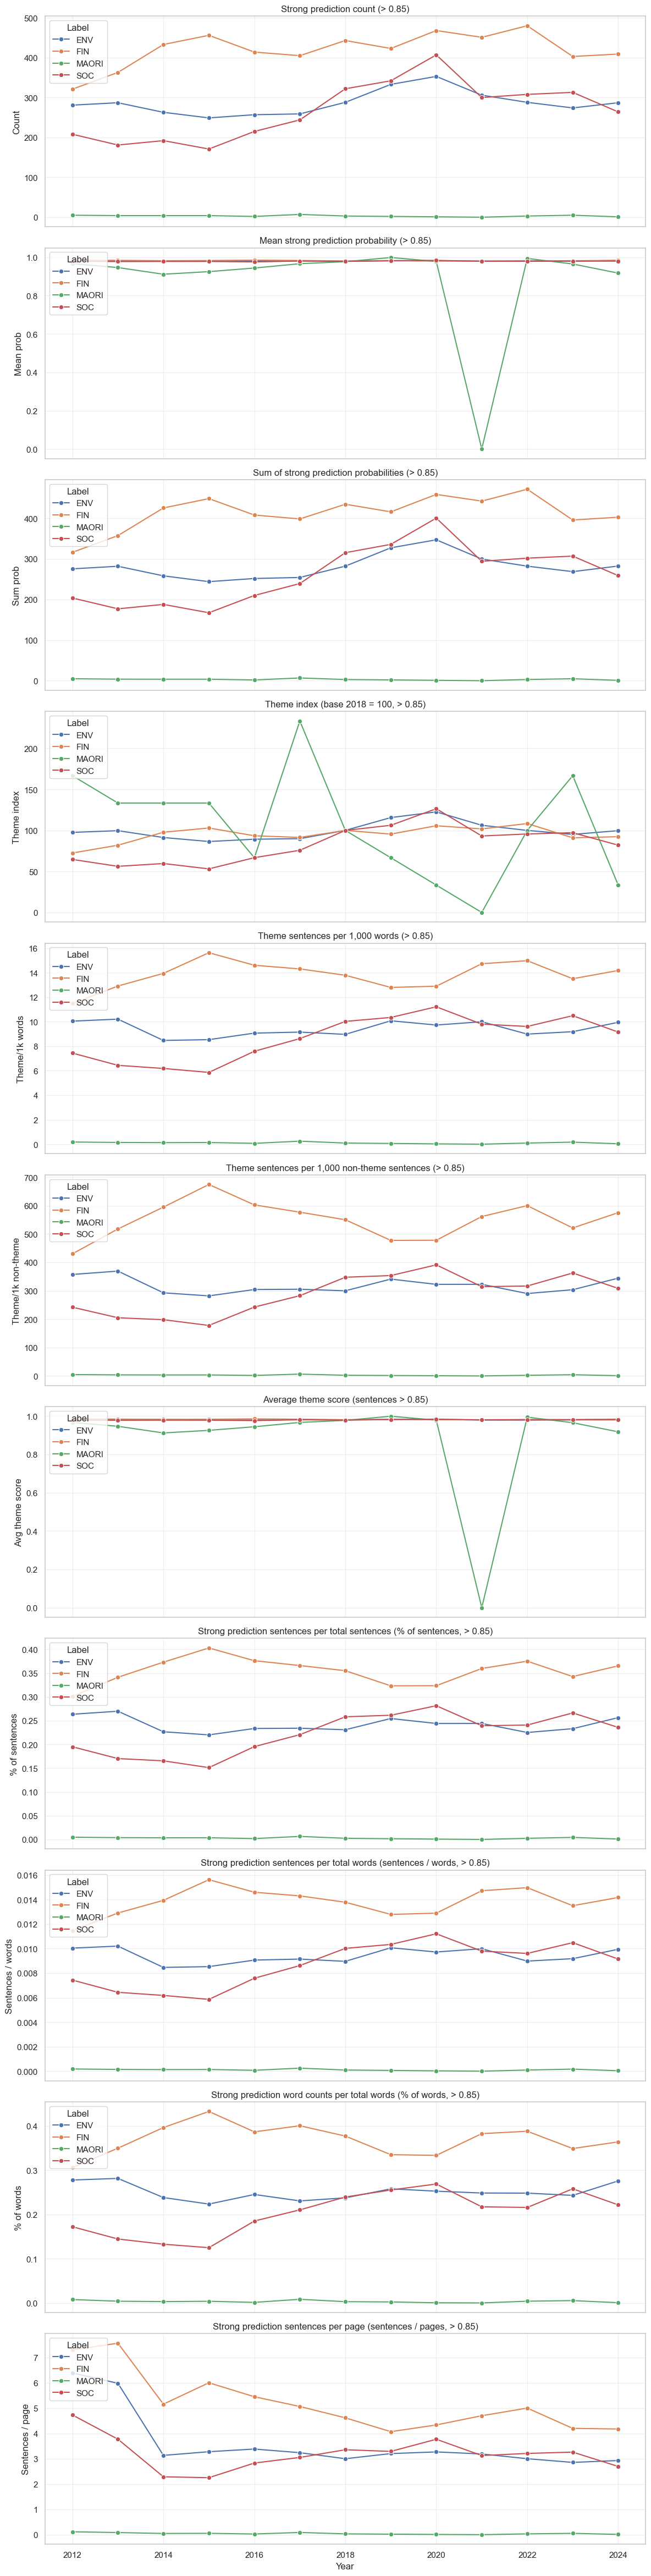

In [10]:
# Combined view for threshold > 0.85 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.85)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.85)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.85)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.85)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.85)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.85)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.85)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.85)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.85)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.85)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.85)"),
]
summary = summaries[0.85]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


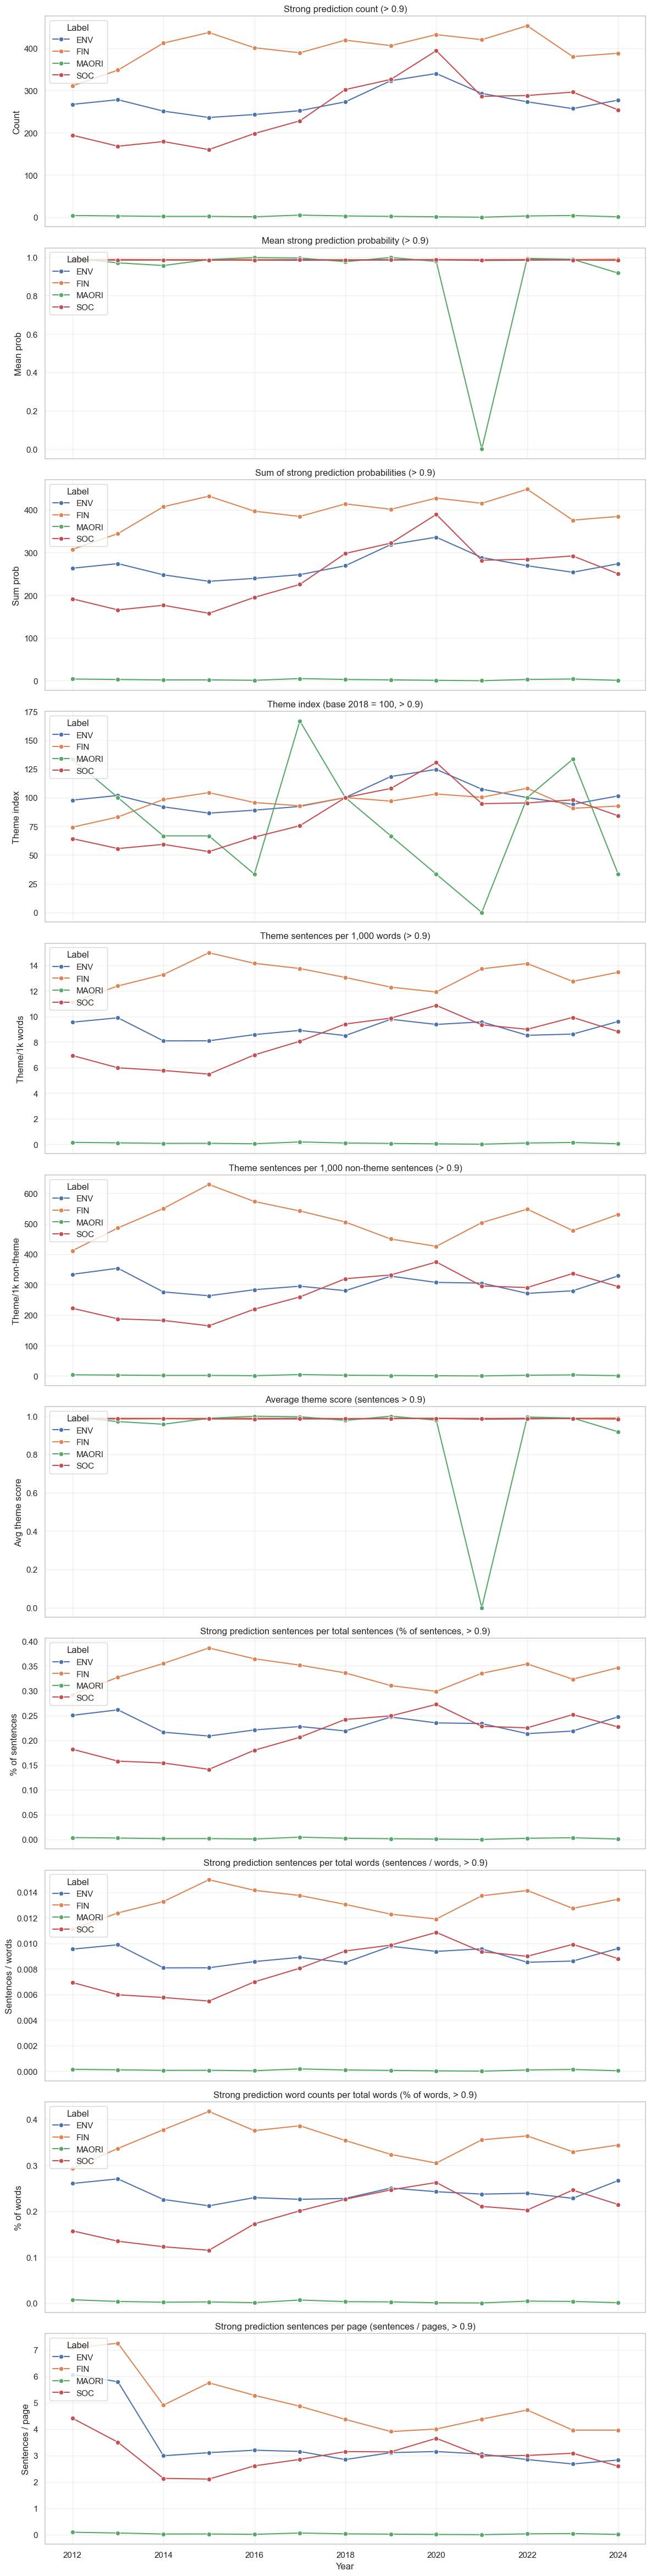

In [11]:
# Combined view for threshold > 0.9 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.9)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.9)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.9)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.9)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.9)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.9)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.9)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.9)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.9)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.9)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.9)"),
]
summary = summaries[0.9]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


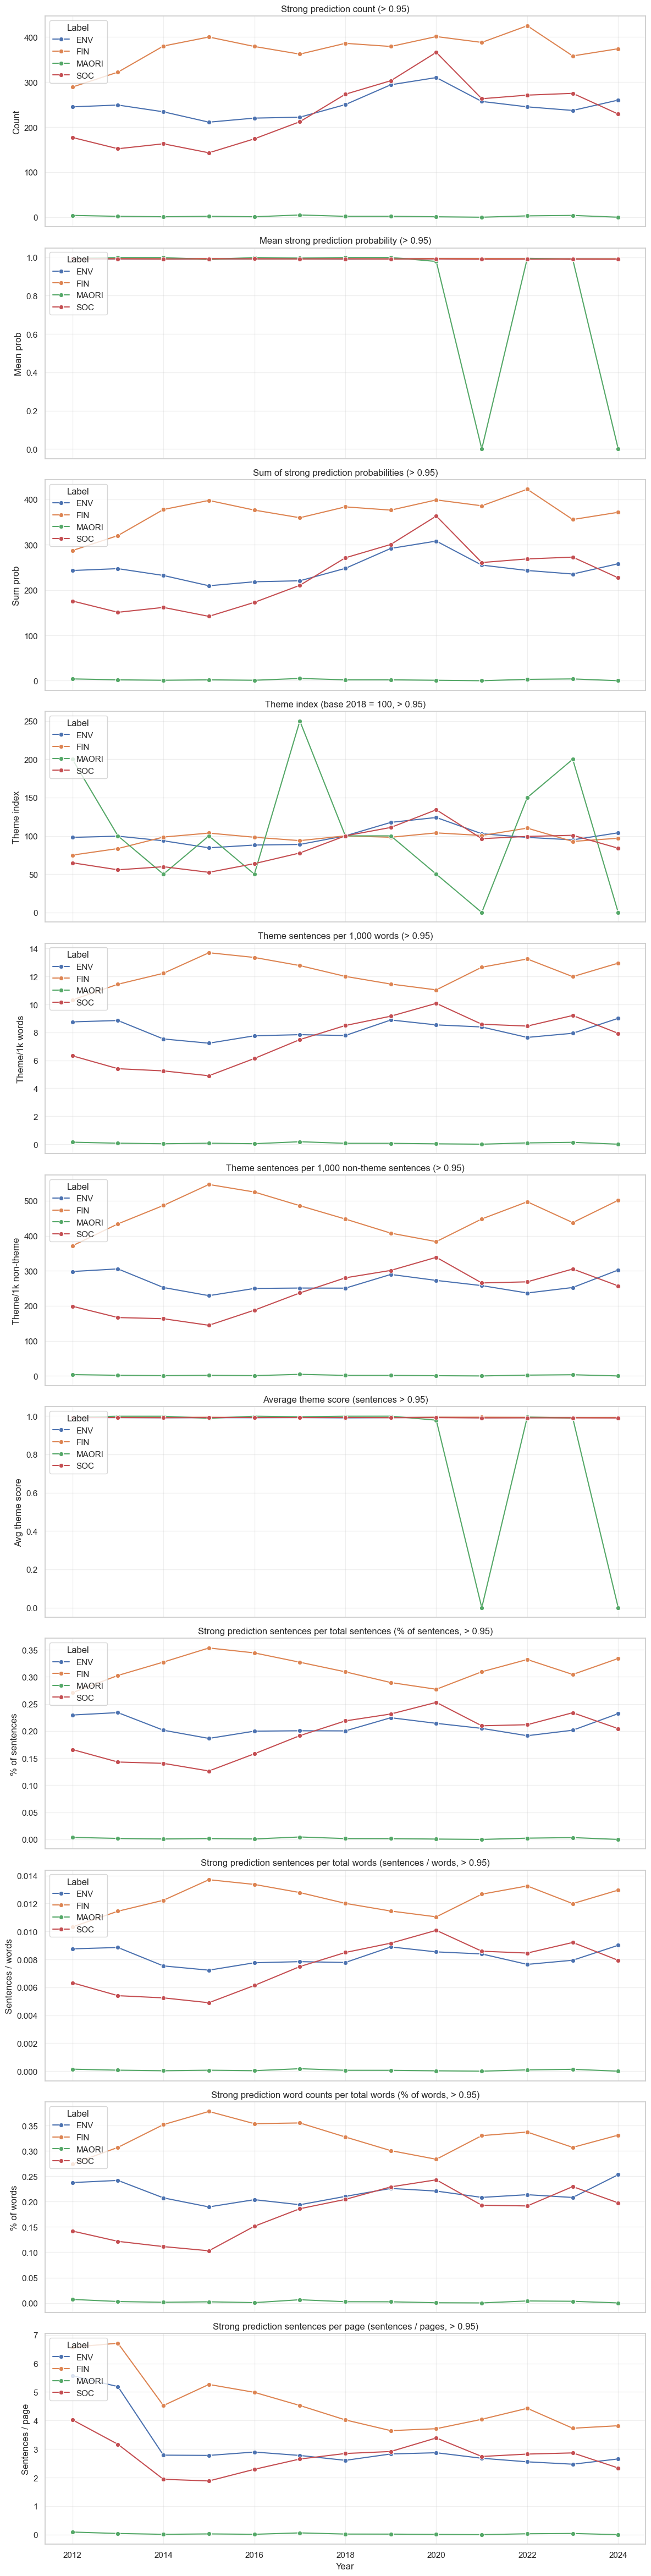

In [12]:
# Combined view for threshold > 0.95 (counts, shares)
fig, axes = plt.subplots(11, 1, figsize=(12, 47), sharex=True)
plot_map = [
    ("over_count", "Strong prediction count (> 0.95)"),
    ("mean_prob_over", "Mean strong prediction probability (> 0.95)"),
    ("sum_prob_over", "Sum of strong prediction probabilities (> 0.95)"),
    ("theme_index_base", "Theme index (base 2018 = 100, > 0.95)"),
    ("theme_rate_per_1000_words", "Theme sentences per 1,000 words (> 0.95)"),
    ("theme_ratio_per_1000_sentences", "Theme sentences per 1,000 non-theme sentences (> 0.95)"),
    ("avg_theme_score_relevant", "Average theme score (sentences > 0.95)"),
    ("over_share", "Strong prediction sentences per total sentences (% of sentences, > 0.95)"),
    ("over_sentence_word_share", "Strong prediction sentences per total words (sentences / words, > 0.95)"),
    ("over_word_share", "Strong prediction word counts per total words (% of words, > 0.95)"),
    ("over_sentences_per_page", "Strong prediction sentences per page (sentences / pages, > 0.95)"),
]
summary = summaries[0.95]
short_labels = {
    "over_count": "Count",
    "mean_prob_over": "Mean prob",
    "sum_prob_over": "Sum prob",
    "theme_index_base": "Theme index",
    "theme_rate_per_1000_words": "Theme/1k words",
    "theme_ratio_per_1000_sentences": "Theme/1k non-theme",
    "avg_theme_score_relevant": "Avg theme score",
    "over_share": "% of sentences",
    "over_sentence_word_share": "Sentences / words",
    "over_word_share": "% of words",
    "over_sentences_per_page": "Sentences / page",
}
for ax, (ycol, title) in zip(axes, plot_map):
    sns.lineplot(data=summary, x="year", y=ycol, hue="label", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_ylabel(short_labels.get(ycol, ycol))
    ax.grid(True, alpha=0.3)
    ax.legend(title="Label", loc="upper left")
axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()


Notes
- over_count: how many sentences per label per year with predicted probability above the chosen threshold.
- over_share: same as over_count / total sentences for that year+label (proportion of strong predictions).
- over_sentence_word_share: strong prediction sentences divided by total words in that year+label grouping.
- over_word_share: total words from strong prediction sentences divided by total words for that year+label grouping.
- over_sentences_per_page: strong prediction sentences divided by page count for that year (requires page_counts.csv).
- over_words_per_page: total words from strong prediction sentences divided by page count for that year (requires page_counts.csv).
- mean_prob_over: average probability for those sentences above the threshold (NaN if none above threshold).
